<a href="https://colab.research.google.com/github/zualexander/mai-aiapp-computer-vision/blob/main/mai_computer_vision_experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tarfile
import os
import splitfolders
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

#Functions

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def plot_accuracy_and_loss(history):

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Download Dataset
from [howto](https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e)

In [ ]:
!wget --no-check-certificate \
    ""http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"" \
    -O "/tmp/dataset.tar.gz"

--2022-05-25 21:14:48--  http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz
Resolving aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)... 132.230.105.132
Connecting to aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)|132.230.105.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541562880 (516M) [application/x-gzip]
Saving to: ‘/tmp/dataset.tar.gz’

/tmp/dataset.tar.gz 100%[===================>] 516.47M  31.2MB/s    in 17s     

2022-05-25 21:15:06 (30.1 MB/s) - ‘/tmp/dataset.tar.gz’ saved [541562880/541562880]



In [ ]:
!mkdir /tmp/dataset 
!tar xf /tmp/dataset.tar.gz --directory=/tmp/dataset

# Datasplit

In [ ]:
splitfolders.ratio("/tmp/dataset/images", output="/tmp/dataset/output",
    seed=1337, ratio=(.75, .25), group_prefix=None, move=False)

Copying files: 4947 files [00:01, 2490.91 files/s]


In [ ]:
ls /tmp/dataset/output/train

BEANS/   CHIPS/      FISH/   JUICE/  PASTA/   SUGAR/         WATER/
CAKE/    CHOCOLATE/  FLOUR/  MILK/   RICE/    TEA/
CANDY/   COFFEE/     HONEY/  NUTS/   SODA/    TOMATO_SAUCE/
CEREAL/  CORN/       JAM/    OIL/    SPICES/  VINEGAR/


In [ ]:
train = keras.utils.image_dataset_from_directory(
    directory='/tmp/dataset/output/train/',
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=32,
    image_size=(256, 256))

validation = keras.utils.image_dataset_from_directory(
    directory='/tmp/dataset/output/val/',
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=32,
    image_size=(256, 256))

# Model

In [ ]:
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=len(train.class_names)
) 

94781440/94765736 [==============================] - 0s 0us/step


##data augmentation layer

## model reconstruction

In [ ]:
model = keras.models.Sequential()

In [ ]:
#FREEZE HERE
#for layer in resnet_model.layers:
#        layer.trainable=False

model.add(resnet_model)

In [ ]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(len(train.class_names), activation='softmax'))

In [ ]:
#compile model
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

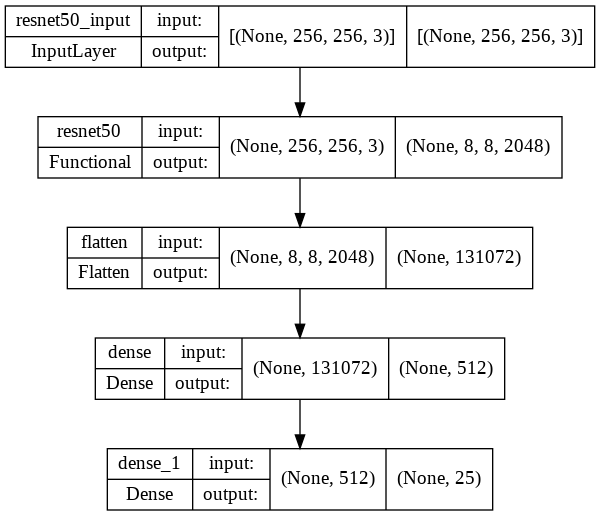

In [ ]:
keras.utils.plot_model(model,show_shapes=True)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!! why not working? do I need to add input layers?

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 25)                12825     
                                                                 
Total params: 90,709,913
Trainable params: 90,656,793
Non-trainable params: 53,120
_________________________________________________________________


# data augmentation

In [ ]:
data_generator_with_aug = keras.preprocessing.image.ImageDataGenerator(
                                   rotation_range=90,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range=[0.0, 0.5]
                                   )

In [ ]:
train_generator = data_generator_with_aug.flow_from_directory(
        "/tmp/dataset/output/train/",
        target_size=(256, 256),
        class_mode='categorical',
        batch_size=32
        )

Found 3699 images belonging to 25 classes.


In [ ]:
data_generator_no_aug =  keras.preprocessing.image.ImageDataGenerator()

In [ ]:
validation_generator = data_generator_with_aug.flow_from_directory(
    "/tmp/dataset/output/val/",
    target_size=(256, 256),
    class_mode='categorical'
    )

Found 1248 images belonging to 25 classes.


In [ ]:
hist = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator
        )

Epoch 1/20
116/116 [==============================] - 97s 835ms/step - loss: 3.1537 - acc: 0.0892 - val_loss: 3.5893 - val_acc: 0.0745
Epoch 2/20
116/116 [==============================] - 94s 808ms/step - loss: 3.0525 - acc: 0.1076 - val_loss: 9.6286 - val_acc: 0.1178
Epoch 3/20
116/116 [==============================] - 95s 815ms/step - loss: 2.9789 - acc: 0.1363 - val_loss: 3.2094 - val_acc: 0.1170
Epoch 4/20
116/116 [==============================] - 95s 814ms/step - loss: 2.9615 - acc: 0.1346 - val_loss: 3.0701 - val_acc: 0.1274
Epoch 5/20
116/116 [==============================] - 94s 813ms/step - loss: 2.9507 - acc: 0.1422 - val_loss: 3.1903 - val_acc: 0.1258
Epoch 6/20
116/116 [==============================] - 94s 808ms/step - loss: 2.9522 - acc: 0.1417 - val_loss: 3.0747 - val_acc: 0.1458
Epoch 7/20
116/116 [==============================] - 94s 812ms/step - loss: 2.8978 - acc: 0.1509 - val_loss: 3.2624 - val_acc: 0.1442
Epoch 8/20
116/116 [==============================] - 9

#Model evaluation

## validation scoring

In [ ]:
#evaluate on unseen data
score = model.evaluate(validation, verbose=0)

In [ ]:
print('Test accuracy:', score[1])

Test accuracy: 0.11298076808452606


In [ ]:
print('Test loss:', score[0])

Test loss: 3.671069860458374


##trainigs history

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


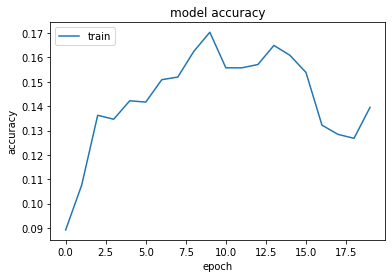

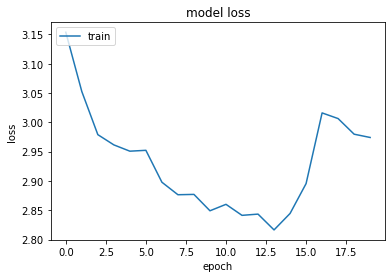

In [ ]:
print(hist.history.keys())
plot_accuracy_and_loss(hist)